In [1]:
from gurobipy import *
from itertools import combinations
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib._color_data as mcd
import random

In [5]:
opt_mod = Model(name = "vessel swap body routing")

Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-24


In [9]:
nodes_requests  = {}
nodes_locations = {}
Pickup_nodes        = []
Pickup_nodes_copy   = []
Delivery_nodes      = []
Delivery_nodes_copy = []

for i in range(n_requests):
    if(Requests["pickup_location"][i] != -1):
        label = "P_" + str(i)
        Pickup_nodes.append(label)
        nodes_requests[label] = i
        nodes_locations[label] = Requests["pickup_location"][i]
        
        label_copy = "P'_" + str(i + n_requests)
        Pickup_nodes_copy.append(label_copy)
        nodes_requests[label_copy] = i
        nodes_locations[label_copy] = Requests["pickup_location"][i]
    
    if(Requests["delivery_location"][i] != -1):
        label = "D_" + str(i + 2*n_requests)
        Delivery_nodes.append(label)
        nodes_requests[label] = i
        nodes_locations[label] = Requests["delivery_location"][i]
        
        label_copy = "D'_" + str(i + 3*n_requests)
        Delivery_nodes_copy.append(label_copy)
        nodes_requests[label_copy] = i
        nodes_locations[label_copy] = Requests["delivery_location"][i]
        
I = Pickup_nodes + Pickup_nodes_copy + Delivery_nodes + Delivery_nodes_copy

S_b = [[] for _ in range(n_bodies)]
for i in [loc for loc in range(n_nodes) if Nodes["is_client"][loc] == -2]:
    for b in range(n_bodies):
        for c in [1,2]:
            label = "S_" + str(i) + "_" + str(b) + "_" + str(c)
            S_b[b].append(label)
            nodes_locations[label] = i
S = [s for s_b in S_b for s in s_b]
            
J_0 = []
for i in range(n_vessels):
    label = "o_v_" + str(i)
    J_0.append(label)
    nodes_locations[label] = Vessels["start_location"][i]
for i in range(n_bodies):
    label = "o_b_" + str(i)
    J_0.append(label)
    nodes_locations[label] = Bodies["start_location"][i]
    
Dummy = ["sink"]
nodes_locations["sink"] = -1

N = J_0 + I + S + Dummy

['o_v_0', 'o_v_1', 'o_b_0', 'o_b_1', 'o_b_2', 'P_0', 'P_1', 'P_2', "P'_3", "P'_4", "P'_5", 'D_6', 'D_7', 'D_8', "D'_9", "D'_10", "D'_11", 'sink']


In [10]:
A_1 = tuplelist()
A_2 = tuplelist()
A_3 = tuplelist()
A_4 = tuplelist()
A_5 = tuplelist()
A_sink = tuplelist()
A_D = tuplelist()
A = tuplelist()

# A_1
for o in J_0 + S:
    for n in N:
        if(o == n):
            continue
        A_1.append((o,n))
###################################################################
# A_2
for p,p_copy in zip(Pickup_nodes,Pickup_nodes_copy):
    A_2.append((p,p_copy))
for p in Pickup_nodes:
    r = nodes_requests[p]
    for n in N:
        if(n[0] == 'P' or n[0] == 'D'):
            if(nodes_requests[n] == r):
                continue
        A_2.append((p,n))
###################################################################
# A_3
for p_copy,d in zip(Pickup_nodes_copy,Delivery_nodes):
    A_3.append((p_copy,d))
for p_copy in Pickup_nodes_copy:
    r = nodes_requests[p_copy]
    for n in N:
        if(n[0] == 'P' or n[0] == 'D'):
            if(nodes_requests[n] == r):
                continue
        A_3.append((p_copy,n))
###################################################################
# A_4
for d,d_copy in zip(Delivery_nodes,Delivery_nodes_copy):
    A_4.append((d,d_copy))
for d in Delivery_nodes:
    r = nodes_requests[d]
    for n in N:
        if(n[0] == 'P' or n[0] == 'D'):
            if(nodes_requests[n] == r):
                continue
        A_4.append((d,n))
###################################################################
# A_5
for d_copy in Delivery_nodes_copy:
    r = nodes_requests[d_copy]
    for n in N:
        if(n[0] == 'P' or n[0] == 'D'):
            if(nodes_requests[n] == r):
                continue
        A_5.append((d_copy,n))
###################################################################
# A_sink
for n in J_0 + I + S:
    A_sink.append((n,Dummy[0]))

A = A_1 + A_2 + A_3 + A_4 + A_5 #+ A_sink

# A_D
for i,j in A:
    if(nodes_locations[i] == nodes_locations[j]):
        A_D.append((i,j))
A_D += A_sink

In [11]:
travel_time = {}
for dep,arr in A:
    time = Distances[nodes_locations[dep]][nodes_locations[arr]] / Params["speed"][0] if nodes_locations[arr] != -1 else 0
    
    if(dep in I and arr in I and nodes_requests[dep] == nodes_requests[arr]):
        service_time = Params["coupling_time"][0] if A_1.select(dep,arr) else Params["decoupling_time"][0]
        r = nodes_requests[dep]
        time = service_time * Requests["num_containers"][r]
            
    travel_time[(dep,arr)] = time

In [12]:
z_v      = []
beta_b   = []
omega_bv = []
x_br     = []
delta_b  = []
gamma_r  = []
tau_a_v  = []
tau_d_v  = []
tau_a_b  = []
tau_d_b  = []
y_v      = []
phi_b    = []

for v in range(n_vessels):
    z_v.append({})
    for arc in A:
        z_v[v][arc] = opt_mod.addVar(name = "z_" + str(v) + "_(" + arc[0] + "," + arc[1] + ")", vtype = GRB.BINARY)

for b in range(n_bodies):
    beta_b.append({})
    for arc in A:
        beta_b[b][arc] = opt_mod.addVar(name = "beta_" + str(b) + "_(" + arc[0] + "," + arc[1] + ")", vtype = GRB.BINARY)

for v in range(n_vessels):
    omega_bv.append([])
    for b in range(n_bodies):
        omega_bv[v].append({})
        for arc in A:
            omega_bv[v][b][arc] = opt_mod.addVar(name = "omega_" + str(b) + "_" + str(v) + "_(" + arc[0] + "," + arc[1] + ")", vtype = GRB.BINARY)

for r in range(n_requests):
    x_br.append([])
    for b in range(n_bodies):
        x_br[r].append({})
        for arc in A:
            x_br[r][b][arc] = opt_mod.addVar(name = "x_" + str(b) + "_" + str(r) + "_(" + arc[0] + "," + arc[1] + ")", vtype = GRB.BINARY)

for b in range(n_bodies):
    delta_b.append({})
    for arc in A:
        delta_b[b][arc] = opt_mod.addVar(name = "delta_" + str(b) + "_(" + arc[0] + "," + arc[1] + ")", vtype = GRB.BINARY)

for r in range(n_requests):
    gamma_r.append(opt_mod.addVar(name = "gamma_" + str(r), vtype = GRB.BINARY))

for v in range(n_vessels):
    tau_a_v.append({})
    for n in N:
        tau_a_v[v][n] = opt_mod.addVar(name = "tau_a_" + str(v) + "_" + n, vtype = GRB.CONTINUOUS, lb = 0)

for v in range(n_vessels):
    tau_d_v.append({})
    for n in N:
        tau_d_v[v][n] = opt_mod.addVar(name = "tau_d_" + str(v) + "_" + n, vtype = GRB.CONTINUOUS, lb = 0)

for b in range(n_bodies):
    tau_a_b.append({})
    for n in N:
        tau_a_b[b][n] = opt_mod.addVar(name = "tau_B_a_" + str(b) + "_" + n, vtype = GRB.CONTINUOUS, lb = 0)

for b in range(n_bodies):
    tau_d_b.append({})
    for n in N:
        tau_d_b[b][n] = opt_mod.addVar(name = "tau_B_d_" + str(b) + "_" + n, vtype = GRB.CONTINUOUS, lb = 0)

for v in range(n_vessels):
    y_v.append({})
    for i in N:
        for j in N:
            if(i == j):
                continue
            y_v[v][(i,j)] = opt_mod.addVar(name = "y_" + str(v) + "_(" + i + "," + j + ")", vtype = GRB.BINARY)

for b in range(n_bodies):
    phi_b.append({})
    for i in N:
        for j in N:
            if(i == j):
                continue
            phi_b[b][(i,j)] = opt_mod.addVar(name = "phi_" + str(b) + "_(" + i + "," + j + ")", vtype = GRB.BINARY)

opt_mod.update()

In [13]:
obj_fn = quicksum(quicksum(travel_time[a]*z_v[v][a] for a in A) for v in range(n_vessels)) + quicksum(Params["unscheduled_cost_coefficient"][0]* (1 - gamma_r[r]) for r in range(n_requests))
opt_mod.setObjective(obj_fn,GRB.MINIMIZE)

In [14]:
# Routing for vessels and bodies costraints

c_2 = []
c_3 = []
c_4 = {}

for v in range(n_vessels):
    c_2.append(
        opt_mod.addConstr(
            quicksum(
                z_v[v][arc] for arc in A.select(J_0[v],"*")) == 1))
    
for v in range(n_vessels):
    c_3.append(
        opt_mod.addConstr(
            quicksum(
                z_v[v][arc] for arc in A_sink) == 1))

for v in range(n_vessels):
    for i in N:
        if(i == J_0[v] or i == "sink"):
            continue
        c_4[(v,i)] = opt_mod.addConstr(
            quicksum(z_v[v][arc] for arc in A.select("*",i)) == quicksum(z_v[v][arc] for arc in A.select(i,"*")))

c_5 = []
c_6 = []
c_7 = {}

for b in range(n_bodies):
    c_5.append(
        opt_mod.addConstr(
            quicksum(
                beta_b[b][arc] for arc in A.select(J_0[n_vessels + b],"*")) == 1))
    
for b in range(n_bodies):
    c_6.append(
        opt_mod.addConstr(
            quicksum(
                beta_b[b][arc] for arc in A_sink) == 1))

for b in range(n_bodies):
    for i in N:
        if(i == J_0[n_vessels + b] or i == "sink"):
            continue
        c_7[(b,i)] = opt_mod.addConstr(
            quicksum(beta_b[b][arc] for arc in A.select("*",i)) == quicksum(beta_b[b][arc] for arc in A.select(i,"*")))
        
c_8 = {}
c_9 = {}

for b in range(n_bodies):
    for arc in A_D:
        c_8[(b,arc)] = opt_mod.addConstr(
            beta_b[b][arc] == delta_b[b][arc] + quicksum(omega_bv[v][b][arc] for v in range(n_vessels)))

for b in range(n_bodies):
    for arc in set(A).difference(A_D):
        c_9[(b,arc)] = opt_mod.addConstr(
            beta_b[b][arc] == quicksum(omega_bv[v][b][arc] for v in range(n_vessels)))

In [15]:
# Sub-tour elimination for vessel routes
c_10 = {}
c_11 = {}
c_12 = {}
c_13 = {}

for v in range(n_vessels):
    for arc in A:
        c_10[(v,arc)] = opt_mod.addConstr(z_v[v][arc] <= y_v[v][arc])

for v in range(n_vessels):
    for i,j in [(i,j) for (i,j) in A if A.select(j,i)]:
        c_11[v,(i,j)] = opt_mod.addConstr(y_v[v][(i,j)] + y_v[v][(j,i)] == 1)
        
for v in range(n_vessels):
    for i,j in [(i,j) for (i,j) in A if not A.select(j,i)]:
        c_12[v,(i,j)]  = opt_mod.addConstr(y_v[v][(i,j)] == 1)
        
for v in range(n_vessels):
    for i,j in A:
        for _,l in A.select(j,"*"):
            if A.select(l,i):
                c_13[v,(i,j,l)] = opt_mod.addConstr(y_v[v][(i,j)] + y_v[v][(j,l)] + y_v[v][(l,i)] <= 2)              

In [16]:
# Sub-tour elimination for body routes
c_14 = {}
c_15 = {}
c_16 = {}
c_17 = {}

for b in range(n_bodies):
    for arc in A:
        c_14[(b,arc)] = opt_mod.addConstr(beta_b[b][arc] <= phi_b[b][arc])

for b in range(n_bodies):
    for i,j in [(i,j) for (i,j) in A if A.select(j,i)]:
        c_15[b,(i,j)] = opt_mod.addConstr(phi_b[b][(i,j)] + phi_b[b][(j,i)] == 1)
        
for b in range(n_bodies):
    for i,j in [(i,j) for (i,j) in A if not A.select(j,i)]:
        c_16[b,(i,j)] = opt_mod.addConstr(phi_b[b][(i,j)] == 1)
        
for b in range(n_bodies):
    for i,j in A:
        for _,l in A.select(j,"*"):
            if A.select(l,i):
                c_17[b,(i,j,l)] = opt_mod.addConstr(phi_b[b][(i,j)] + phi_b[b][(j,l)] + phi_b[b][(l,i)] <= 2)              

In [17]:
# Capacity constraints
c_18 = {}
c_19 = {}

for b in range(n_bodies):
    for arc in A:
        c_18[v,arc] = opt_mod.addConstr(
            quicksum(
                Requests["num_containers"][r]*x_br[r][b][arc] for r in range(n_requests)) <= Params["body_capacity"][0]*beta_b[b][arc])

for v in range(n_vessels):
    for arc in A:
        c_19[v,arc] = opt_mod.addConstr(
            quicksum(
                omega_bv[v][b][arc] for b in range(n_bodies)) <= Params["max_bodies"][0]*z_v[v][arc])

In [18]:
# Serving requests
c_20 = {}
c_21 = {}
c_22 = {}
c_23 = {}
c_24 = {}

for i in Pickup_nodes + Delivery_nodes:
    r = nodes_requests[i]
    n = int(i[2:]) + n_requests
    copy_i = i[0] + "'_" + str(n)
    arc = A.select(i,copy_i)[0]
    c_20[i] = opt_mod.addConstr(
        quicksum(x_br[r][b][arc] for b in range(n_bodies)) == gamma_r[r])

for b in range(n_bodies):
    for p in Pickup_nodes:
        r = nodes_requests[p]
        if(Requests["pickup_location"][r] == -1 or Requests["delivery_location"][r] == -1):
            continue
        n = int(p[2:])
        copy_p   = "P'_" + str(n + n_requests)
        d        = "D_"  + str(n + 2*n_requests)
        copy_d   = "D'_" + str(n + 3*n_requests)
        arc_p = A_2.select(p,copy_p)[0]
        arc_d = A_4.select(d,copy_d)[0]
        c_21[b,i] = opt_mod.addConstr(x_br[r][b][arc_p] == x_br[r][b][arc_d])

for b in range(n_bodies):
    for i in Pickup_nodes:
        r = nodes_requests[i]
        if(Requests["pickup_location"][r] == -1 or Requests["delivery_location"][r] == -1):
            continue
        copy_d = "D'_" + str(int(i[2:]) + 3*n_requests)
        for j in N:
            if(j == i or j == copy_d or j == "sink"):
                continue
            c_22[b,i,j] = opt_mod.addConstr(
                                        quicksum(x_br[r][b][A.select(j,k)[0]] for k in N if k != i and A.select(j,k)) ==
                                        quicksum(x_br[r][b][A.select(k,j)[0]] for k in N if k != copy_d and A.select(k,j)))
    
for i in Delivery_nodes:
    r = nodes_requests[i]
    if(Requests["pickup_location"][r] != -1):
        continue
    b = Requests["at_body"][r]
    copy_i = "D'_" + str(int(i[2:]) + n_requests)
    arc = A_4.select(i,copy_i)[0]
    c_23[i] = opt_mod.addConstr(x_br[r][b][arc] == gamma_r[r])

for i in N:
    for r in range(n_requests):
        for b1,b2 in combinations(range(n_bodies),r=2):
            c_24[i,r,b1,b2] = opt_mod.addConstr(
                                                quicksum(x_br[r][b1][arc] for arc in A.select("*",i)) +
                                                quicksum(x_br[r][b2][arc] for arc in A.select(i,"*")) <= 1)

In [19]:
# Updating arrival/departure times
T_max = max(Requests["delivery_to"])
c_25 = {}
c_26 = {}

for v in range(n_vessels):
    for arc in A:
        c_25[v,arc] = opt_mod.addConstr(tau_a_v[v][arc[1]] >= 
                                        tau_d_v[v][arc[0]] + travel_time[arc] * z_v[v][arc] - T_max * (1 - z_v[v][arc]))
    
for b in range(n_bodies):
    for arc in A:
        c_26[b,arc] = opt_mod.addConstr(tau_a_b[b][arc[1]] >= 
                                        tau_d_b[b][arc[0]] + travel_time[arc] * beta_b[b][arc] - T_max * (1 - beta_b[b][arc]))

In [20]:
# Departures after arrivals
c_27 = {}
c_28 = {}

for v in range(n_vessels):
    for i in N:
        c_27[v,i] = opt_mod.addConstr(tau_d_v[v][i] >= tau_a_v[v][i])
    
for b in range(n_bodies):
    for i in N:
        c_28[b,i] = opt_mod.addConstr(tau_d_b[b][i] >= tau_a_b[b][i])

In [21]:
# Attaching and detaching times
c_29 = {}
c_30 = {}

for v in range(n_vessels):
    for b in range(n_bodies):
        for i in N:
            if(i == "o_b_" + str(b) or i == "sink"):
                continue
            c_29[v,b,i] = opt_mod.addConstr(tau_d_v[v][i] >= 
                                            tau_a_v[v][i] + Params["decoupling_time"][0] +
                                            T_max * quicksum(omega_bv[v][b][arc] for arc in A.select("*",i)) -
                                            T_max * quicksum(omega_bv[v][b][arc] for arc in A.select(i,"*")) -
                                            T_max)
            
            c_30[v,b,i] = opt_mod.addConstr(tau_d_v[v][i] >= 
                                            tau_a_v[v][i] + Params["coupling_time"][0] -
                                            T_max * quicksum(omega_bv[v][b][arc] for arc in A.select("*",i)) +
                                            T_max * quicksum(omega_bv[v][b][arc] for arc in A.select(i,"*")) -
                                            T_max)

In [22]:
# Vessel arrives before body
c_31 = {}
c_32 = {}
c_33 = {}
c_34 = {}

for v in range(n_vessels):
    for b in range(n_bodies):
        for i in N:
            c_31[v,b,i] = opt_mod.addConstr(tau_a_b[b][i] >=
                                            tau_a_v[v][i] + 
                                            T_max * quicksum(omega_bv[v][b][arc] for arc in A.select("*",i)) - T_max)
            c_32[v,b,i] = opt_mod.addConstr(tau_d_b[b][i] >=
                                            tau_d_v[v][i] + 
                                            T_max * quicksum(omega_bv[v][b][arc] for arc in A.select("*",i)) - T_max)
            c_33[v,b,i] = opt_mod.addConstr(tau_a_v[v][i] >=
                                            tau_a_b[b][i] + 
                                            T_max * quicksum(omega_bv[v][b][arc] for arc in A.select(i,"*")) - T_max)
            c_34[v,b,i] = opt_mod.addConstr(tau_d_v[v][i] >=
                                            tau_d_b[b][i] + 
                                            T_max * quicksum(omega_bv[v][b][arc] for arc in A.select(i,"*")) - T_max)

In [23]:
# Time windows
c_35 = {}
c_36 = {}
c_37 = {}
c_38 = {}

for b in range(n_bodies):
    for i in Pickup_nodes:
        r = nodes_requests[i]
        t = Requests["pickup_from"][r]
        c_35[b,i] = opt_mod.addConstr(tau_d_b[b][i] >= t * gamma_r[r])
        
    for i in Delivery_nodes:
        r = nodes_requests[i]
        t = Requests["delivery_from"][r]
        c_36[b,i] = opt_mod.addConstr(tau_d_b[b][i] >= t * gamma_r[r])
        
    for i in Pickup_nodes_copy:
        r = nodes_requests[i]
        t = Requests["pickup_to"][r]
        c_37[b,i] = opt_mod.addConstr(tau_a_b[b][i] <= t * gamma_r[r])
        
    for i in Delivery_nodes_copy:
        r = nodes_requests[i]
        t = Requests["delivery_to"][r]
        c_38[b,i] = opt_mod.addConstr(tau_a_b[b][i] <= t * gamma_r[r])

In [24]:
# Transfers at non-client nodes
c_39 = {}
c_40 = {}
c_41 = {}

for b in range(n_bodies):
    for v in range(n_vessels):
        for s in set(S).difference(S_b[b]):
            c_39[b,v,s] = opt_mod.addConstr(
                                quicksum(omega_bv[v][b][arc] for arc in A.select("*",s)) == 
                                quicksum(omega_bv[v][b][arc] for arc in A.select(s,"*")))
    for s_1 in [s_b for s_b in S_b[b] if s_b[-1] == "1"]:
        s_2 = s_1[:-1] + "2"
        c_40[b,v,s_1] = opt_mod.addConstr(
                                quicksum(beta_b[b][arc] for arc in A.select("*",s_1)) == delta_b[b][s_1,s_2])
        c_41[b,v,s_2] = opt_mod.addConstr(
                                quicksum(beta_b[b][arc] for arc in A.select(s_2,"*")) == delta_b[b][s_1,s_2])

In [25]:
# Valid inequalities

c_44 = {}
c_45 = {}

for i in Pickup_nodes:
    r = nodes_requests[i]
    c_44[i] = opt_mod.addConstr(quicksum(
                                    quicksum(
                                        x_br[r][b][arc] for arc in A.select("*",i))
                                    for b in range(n_bodies)) == 0)

for i in Delivery_nodes_copy:
    r = nodes_requests[i]
    c_45[i] = opt_mod.addConstr(quicksum(
                                    quicksum(
                                        x_br[r][b][arc] for arc in A.select(i,"*"))
                                    for b in range(n_bodies)) == 0)

In [26]:
opt_mod.update()
opt_mod.Params.MIPGap=0.3
opt_mod.optimize()
print(f'Objective Function Value: {opt_mod.objVal}')

Set parameter MIPGap to value 0.3
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 21959 rows, 7739 columns and 86042 nonzeros
Model fingerprint: 0x8e7e9254
Variable types: 180 continuous, 7559 integer (7559 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+04]
  Objective range  [2e+01, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+04]
Found heuristic solution: objective 30000.000000
Presolve removed 11320 rows and 1993 columns
Presolve time: 0.26s
Presolved: 10639 rows, 5746 columns, 51723 nonzeros
Variable types: 180 continuous, 5566 integer (5566 binary)

Root relaxation: objective 4.589804e+01, 5294 iterations, 1.22 seconds (0.58 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   45.89804    0   95 30000.0000   45.89

In [27]:
for v in range(n_vessels):
    tm = []
    t = tau_a_v[v]
    arcs = z_v[v]
    tm.append((J_0[v],0))
    for arc in arcs:
        if(arcs[arc].x == 1):
            tm.append((arc[1],t[arc[1]].x))
    for i in sorted(tm,key=lambda x : x[1]):
        print(i)
    print()

('o_v_0', 0)
("P'_3", 20736.999999999996)
('D_8', 20769.417417417415)
('D_6', 20784.417417417415)
("D'_11", 20784.417417417415)
('o_b_2', 20784.417417417415)
("D'_9", 20784.417417417415)
('sink', 20784.41741741742)

('o_v_1', 0)
('o_b_2', 0.0)
('P_1', 192.1771771771164)
("P'_5", 7905.999999999987)
('o_v_0', 8113.492492492278)
('P_0', 8161.225225225007)
('sink', 8176.225225225229)



In [28]:
t = beta_b[2]
for arc in t:
    if(t[arc].x == 1):
        print(arc)

('o_v_0', 'P_0')
('o_b_1', 'D_6')
('o_b_2', 'P_1')
('P_0', "P'_3")
('P_2', "P'_5")
('P_1', 'P_2')
("P'_3", 'D_8')
("P'_5", 'o_v_0')
('D_6', "D'_9")
('D_8', "D'_11")
("D'_9", 'sink')
("D'_11", 'o_b_1')


In [29]:
for b in range(n_bodies):
    tm = []
    t = tau_a_b[b]
    arcs = beta_b[b]
    tm.append((J_0[n_vessels + b],0))
    for arc in arcs:
        if(arcs[arc].x == 1):
            tm.append((arc[1],t[arc[1]].x))
    for i in sorted(tm,key=lambda x : x[1]):
        print(i)
    print()

('o_b_0', 0)
("D'_10", 0.0)
('o_v_0', 0.0)
('sink', 0.0)

('o_b_1', 0)
('o_b_2', 0.0)
('P_1', 7841.0)
("P'_4", 7871.0)
("P'_5", 7871.0)
('D_7', 16607.0)
('o_v_0', 16607.0)
("D'_10", 16637.0)
('sink', 16637.0)

('o_b_2', 0)
('P_1', 7726.0)
('P_2', 7726.0)
("P'_5", 7906.0)
('o_v_0', 8113.492492492278)
('P_0', 17464.732732732846)
("P'_3", 20736.999999999996)
('D_8', 23929.0)
("D'_11", 24109.0)
('D_6', 37865.99999999999)
('o_b_1', 37865.99999999999)
("D'_9", 38076.0)
('sink', 38076.0)



In [30]:
def _get_path(index,vessel):
    arc_list     = z_v[index]     if vessel == 1 else beta_b[index]
    arrival_time = tau_a_v[index] if vessel == 1 else tau_a_b[index]  
    path = [arc for arc in arc_list if arc_list[arc].x == 1]
    path = sorted(path,key = lambda x : arrival_time[x[1]].x)
    return path

def plot_path(index,vessel):
    G = nx.DiGraph()
    path = _get_path(index,vessel)
    G.add_edges_from(path)
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G,pos,node_color="#90EE90",node_size = 500)
    nx.draw_networkx_edges(G,pos,edgelist=G.edges())
    nx.draw_networkx_labels(G,pos)
    plt.show()

def plot_all_category_paths(is_vessels = 0):
    colors = ["tab:red","tab:blue","tab:green"]
    edge_colors = {}
    G = nx.MultiDiGraph()
    n = n_vessels if is_vessels > 0 else n_bodies
    for i in range(n):
        path = _get_path(i,is_vessels)
        G.add_edges_from(path)
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G,pos,node_color="#90EE90",node_size = 500)
    nx.draw_networkx_labels(G,pos)
    for i in range(n):
        path = _get_path(i,is_vessels)
        radius = (-1)**i * 0.1 * i
        style = "arc3,rad=" + str(radius)
        nx.draw_networkx_edges(G,pos,edgelist=path,connectionstyle=style, edge_color=colors[i])
    plt.show()    

def plot_all_paths():
    colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
    G = nx.MultiDiGraph()
    for is_vessels in [0,1]:
        n = n_vessels if is_vessels > 0 else n_bodies
        for i in range(n):
            path = _get_path(i,is_vessels)
            G.add_edges_from(path)
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G,pos,node_color="#90EE90",node_size = 500)
    nx.draw_networkx_labels(G,pos)
    
    patches = []
    
    for is_vessels in [0,1]:
        n = n_vessels if is_vessels > 0 else n_bodies
        for i in range(n):
            path = _get_path(i,is_vessels)
            curve = 0.1 if is_vessels == 0 else 0.3
            radius = (-1)**i * curve * i
            style = "arc3,rad=" + str(radius)
            nx.draw_networkx_edges(G,pos,edgelist=path,connectionstyle=style, edge_color=colors[n_bodies * is_vessels + i])
            
            label = "Vessel " if is_vessels else "Body "
            label += str(i)
            patches.append(mpatches.Patch(color=colors[n_bodies * is_vessels + i], label=label))

    plt.legend(handles=patches)
    plt.show()        

In [31]:
def _get_shared_routes(vessel,body):
    arcs = omega_bv[vessel][body]
    locs = []
    for arc in arcs:
        if arcs[arc].x == 1:
            locs.append((nodes_locations[arc[0]],nodes_locations[arc[1]]))
    return locs

def _draw_edges(G,pos,path,i,is_vessels,colors):
    if is_vessels:
        radius = (-1)**i * 0.5 * (i + 1)
        style  = "arc3,rad=" + str(radius)
        nx.draw_networkx_edges(G,pos,edgelist=path,width = 3,connectionstyle=style, edge_color=colors[n_bodies * is_vessels + i])
        return

    for arc in path:
        radius = (-1)**i * 0.1 * i
        for v in range(n_vessels):
            if arc in _get_shared_routes(v,i):
                radius = (-1)**v * 0.5 * (v + 1) - 0.05*(i + 1)
                break
        style  = "arc3,rad=" + str(radius)
        nx.draw_networkx_edges(G,pos,edgelist=[arc],width = 3,connectionstyle=style, edge_color=colors[n_bodies * is_vessels + i],style="dashed")

def _print_information():
    for v in range(n_vessels):
        print("Vessel: {:1} - start location: {}".format(v,Vessels["start_location"][v]))
    for b in range(n_bodies):
        print("Body: {:3} - start location: {}".format(b,Bodies["start_location"][b]))
    for r in range(n_requests):
        if(gamma_r[r].x == 0):
            print("Request",r,"outsourced by trucks!")
            continue
        r_p_l = Requests["pickup_location"][r]
        r_d_l = Requests["delivery_location"][r]
        r_p_node = "P_" + str(r)
        r_p_copy_node = "P'_" + str(r + n_requests)
        r_d_node = "D_" + str(r + 2 * n_requests)
        
        if r_p_l == -1:
            r_b   = Requests["at_body "][r]
            r_d_t = round(tau_a_b[r_b][r_d_node].x,2)
            print("Request",r,"handled by body",r_b,"- Delivery at location",r_d_l,"at",r_d_t)
            continue
        
        for b in range(n_bodies):
            if x_br[r][b][A.select(r_p_node,r_p_copy_node)[0]].x == 1:
                r_p_t = round(tau_a_b[b][r_p_node].x,2)
                if r_d_l == -1:            
                    print("Request",r,"handled by body",r_b,"- Pickup at location",r_p_l,"at",r_p_t)
                    continue
                r_d_t = round(tau_a_b[b][r_d_node].x,2)
                print("Request",r,"handled by body",b,"- Pickup at location",r_p_l,"at",r_p_t," - Delivery at location",r_d_l,"at",r_d_t)

In [32]:
def _location_paths(index,is_vessels,timing=False):
    arc_list = z_v[index]     if is_vessels == 1 else beta_b[index]
    arr_time = tau_a_v[index] if is_vessels == 1 else tau_a_b[index] 
    dep_time = tau_d_v[index] if is_vessels == 1 else tau_d_b[index]
    path = [arc for arc in arc_list if arc_list[arc].x == 1]
    path_locations = []
    timings = {}
    for arc in path:
        dep = nodes_locations[arc[0]]
        arr = nodes_locations[arc[1]]
        if dep != arr and arr != -1:
            if timing:
                t_dep = round(dep_time[arc[0]].x,2)
                t_arr = round(arr_time[arc[1]].x,2)
                timings[(dep,arr)] = (t_dep,t_arr)
            path_locations.append((dep,arr))
    if timing:
        return path_locations,timings
    return path_locations
    
def plot_paths_locations():
    colors = [x for x in mcd.TABLEAU_COLORS.values()]
    G = nx.MultiDiGraph()
    for is_vessels in [0,1]:
        n = n_vessels if is_vessels else n_bodies
        for i in range(n):
            path = _location_paths(i,is_vessels)
            G.add_edges_from(path)
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G,pos,node_color="#90EE90",node_size = 500)
    nx.draw_networkx_labels(G,pos)
    
    patches = []
    
    for is_vessels in [0,1]:
        n = n_vessels if is_vessels > 0 else n_bodies
        for i in range(n):
            path,timing = _location_paths(i,is_vessels,True)
            _draw_edges(G,pos,path,i,is_vessels,colors)
            label = "Vessel " if is_vessels else "Body "
            label += str(i)
            patches.append(mpatches.Patch(color=colors[n_bodies * is_vessels + i], label=label))
    
    _print_information()
    plt.legend(handles=patches)
    plt.show()

In [33]:
Requests

,Request,pickup_location,pickup_from,pickup_to,delivery_location,delivery_from,delivery_to,num_containers,at_body
0,0,2,20527,26185,3,37866,39038,14,-1
1,1,0,2580,7871,1,16607,17462,2,-1
2,2,0,7726,12402,3,23530,24109,12,-1


Vessel: 0 - start location: 1
Vessel: 1 - start location: 3
Body:   0 - start location: 1
Body:   1 - start location: 3
Body:   2 - start location: 3
Request 0 handled by body 2 - Pickup at location 2 at 17464.73  - Delivery at location 3 at 37866.0
Request 1 handled by body 1 - Pickup at location 0 at 7841.0  - Delivery at location 1 at 16607.0
Request 2 handled by body 2 - Pickup at location 0 at 7726.0  - Delivery at location 3 at 23929.0


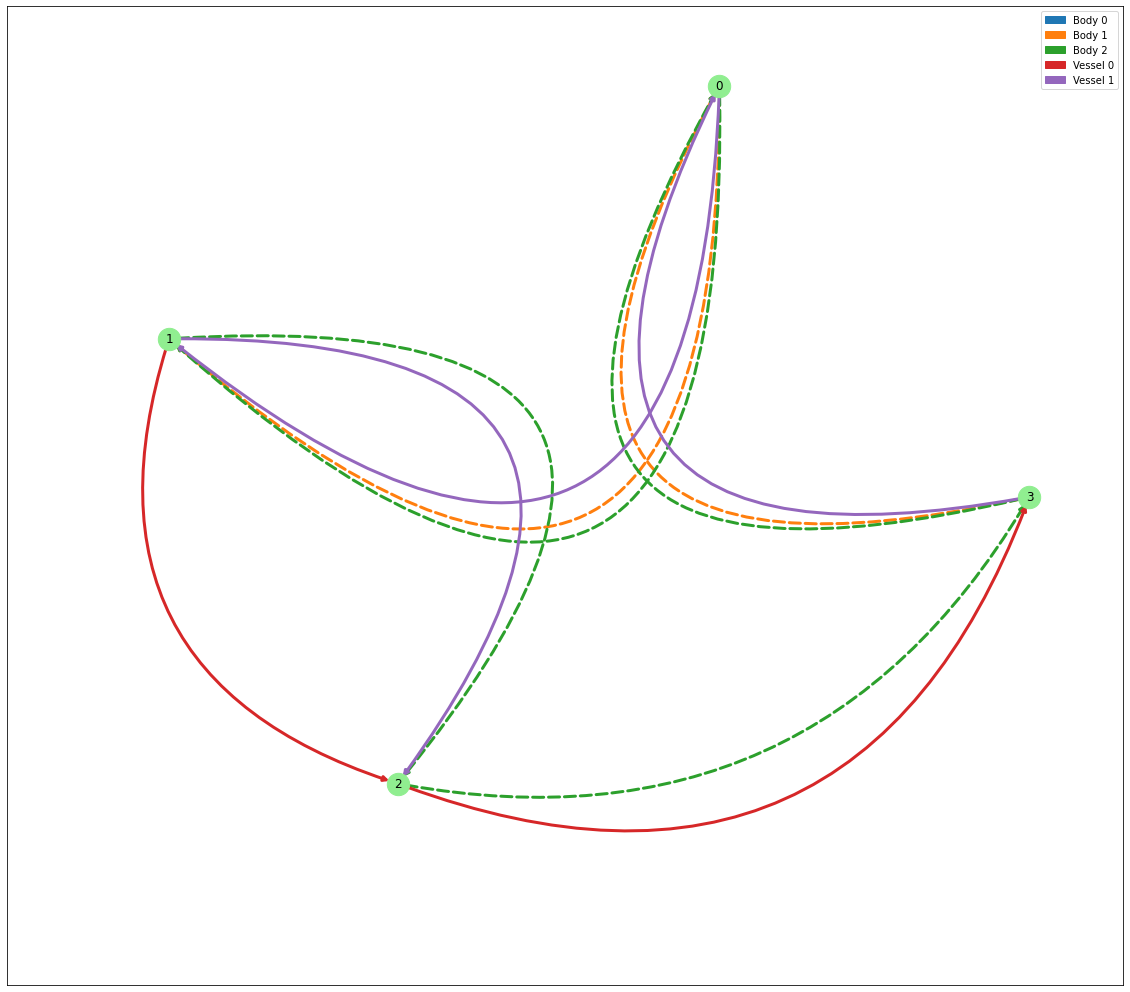

In [35]:
plt.figure(figsize=(20,18))
plot_paths_locations()